<h1>Using pre-trained embeddings with TensorFlow Hub</h1>

This notebook illustrates:
<ol>
    <li>How to instantiate a TensorFlow Hub module</li>
    <li>How to find pre-trained TensorFlow Hub modules for a variety of purposes</li>
    <li>How to examine the embeddings of a Hub module</li>
    <li>How one Hub module composes representations of sentences from individual words</li>
    <li>How to assess word embeddings using a semantic similarity test</li>
</ol>

In [14]:
# change these to try this notebook out 
#BUCKET = 'cloud-training-demos-ml'
#PROJECT = 'cloud-training-demos'
#REGION = 'us-central1'

Install the TensorFlow Hub library

In [15]:
!pip install -q tensorflow-hub

In [16]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import scipy
import math

#os.environ['BUCKET'] = BUCKET
#os.environ['PROJECT'] = PROJECT
#os.environ['REGION'] = REGION
#os.environ['TFVERSION'] = '1.8'

In [17]:
import os
output = os.popen("gcloud config get-value project").readlines()
project_name = output[0][:-1]

# change these to try this notebook out
PROJECT = project_name
BUCKET = project_name
#BUCKET = BUCKET.replace("qwiklabs-gcp-", "inna-bckt-")
REGION = 'europe-west1'  ## note: Cloud ML Engine not availabe in europe-west3!

# set environment variables:
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
os.environ['TFVERSION'] = '1.8'

print(PROJECT)
print(BUCKET)
print(REGION)



qwiklabs-gcp-db7a16df178449d6
qwiklabs-gcp-db7a16df178449d6
europe-west1


In [18]:
import tensorflow as tf
print(tf.__version__)

1.8.0


<h2>TensorFlow Hub Concepts</h2>

TensorFlow Hub is a library for the publication, discovery, and consumption of reusable parts of machine learning models. A module is a self-contained piece of a TensorFlow graph, along with its weights and assets, that can be reused across different tasks in a process known as transfer learning, which we covered as part of the course on Image Models.

To download and use a module, it's as easy as:

However, because modules are self-contained parts of a TensorFlow graph, in order to actually collect values from a module, you'll need to evaluate it in the context of a session.

First, let's explore what hub modules there are. Go to [the documentation page](https://www.tensorflow.org/hub/modules) and explore a bit.

Note that TensorFlow Hub has modules for Images, Text, and Other. In this case, we're interested in a Text module, so navigate to the Text section.

Within the Text section, there are a number of modules. If you click on a link, you'll be taken to a page that describes the module and links to the original paper where the model was proposed. Click on a model in the Word2Vec section of the page.

Note the details section, which describes what the module expects as input, how it preprocesses data, what it does when it encounters a word it hasn't seen before (OOV means "out of vocabulary") and in this case, how word embeddings can be composed to form sentence embeddings.

Finally, note the URL of the page. This is the URL you can copy to instantiate your module.

### nnlm-en-dim50: [https://tfhub.dev/google/nnlm-en-dim50/1](https://tfhub.dev/google/nnlm-en-dim50/1)

Token based text embedding trained on English Google News 7B corpus.

* Overview: Text embedding based on feed-forward Neural-Net Language Models[1] with pre-built OOV. Maps from text to 50-dimensional embedding vectors.

Example use

```
embed = hub.Module("https://tfhub.dev/google/nnlm-en-dim50/1")
embeddings = embed(["cat is on the mat", "dog is in the fog"])
```

* Details: Based on NNLM with two hidden layers.
* Input: The module takes a batch of sentences in a 1-D tensor of strings as input.
* Preprocessing: The module preprocesses its input by splitting on spaces.
* Out of vocabulary tokens: Small fraction of the least frequent tokens and embeddings (~2.5%) are replaced by hash buckets. Each hash bucket is initialized using the remaining embedding vectors that hash to the same bucket.
* Sentence embeddings: Word embeddings are combined into sentence embedding using the sqrtn combiner (see `tf.nn.embedding_lookup_sparse`).

References
[1] Yoshua Bengio, Réjean Ducharme, Pascal Vincent, Christian Jauvin. A Neural Probabilistic Language Model. Journal of Machine Learning Research, 3:1137-1155, 2003.



<h2>Task 1: Create an embedding using the NNLM model</h2>

To complete this task:
<ol>
    <li>Find the module URL for the NNLM 50 dimensional English model</li>
    <li>Use it to instantiate a module as 'embed'</li>
    <li>Print the embedded representation of "cat"</li>
</ol>

NOTE: downloading hub modules requires downloading a lot of data. Instantiating the module will take a few minutes.

In [19]:
# Task 1
embed = hub.Module("https://tfhub.dev/google/nnlm-en-dim50/1")
embeddings = embed(["cat"])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    print(sess.run(embeddings))

INFO:tensorflow:Initialize variable module_2/embeddings/part_0:0 from checkpoint b'/tmp/tfhub_modules/7f07056e3a4c9f125d5bd920ef3883605d8556a8/variables/variables' with embeddings


I0315 07:54:24.504893 140120625735424 tf_logging.py:116] Initialize variable module_2/embeddings/part_0:0 from checkpoint b'/tmp/tfhub_modules/7f07056e3a4c9f125d5bd920ef3883605d8556a8/variables/variables' with embeddings


[[ 0.11233182 -0.3176392  -0.01661182 -0.07224456  0.18654485 -0.13343827
   0.14713244 -0.05857142 -0.1187038  -0.09351522  0.3228137  -0.07136346
  -0.09905618  0.12076239 -0.13954093 -0.00105632  0.31129223  0.09696656
   0.1131188  -0.2877357   0.02663439  0.11532657 -0.1753378  -0.11511131
  -0.1570579   0.20969287 -0.15480006 -0.00777875  0.13566507  0.07828814
   0.08037776 -0.00566911 -0.17601766  0.04775887  0.0203435  -0.11961495
  -0.01772922 -0.02686167 -0.09766243  0.16661587  0.19552311 -0.06655143
   0.07954271 -0.14783832 -0.00695672  0.22246888 -0.14037196 -0.12318342
  -0.02290071  0.04016034]]


When I completed this exercise, I got a vector that looked like:
[[ 0.11233182 -0.3176392  -0.01661182...]]

<h2>Task 2: Assess the Embeddings Informally</h2>

<ol>
    <li>Identify some words to test</li>
    <li>Retrieve the embeddings for each word</li>
    <li>Determine what method to use to compare each pair of embeddings</li>
</ol>    

So, now we have some vectors but the question is, are they any good? One way of testing whether they are any good is to try them for your task. But, first, let's just take a peak. 

For our test, we'll need three common words such that two of the words are much closer in meaning than the third.

In [24]:
word_1 = "coffee"
word_2 = "tea"
word_3 = "computer"

Now, we'll use the same process of using our Hub module to generate embeddings but instead of printing the embeddings, capture them in a variable called 'my_embeddings'.

In [25]:
# Task 2b
embeddings = embed([word_1, word_2, word_3])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    my_embeddings = sess.run(embeddings)

print(my_embeddings)

[[ 0.12924498 -0.23980999 -0.17375998 -0.047901    0.16785999 -0.19357198
   0.06755     0.013849   -0.18618499  0.07042599  0.05466    -0.23534898
  -0.050857   -0.09339199 -0.12249999  0.038179    0.22747898  0.13894598
  -0.16045299  0.052932   -0.060179   -0.20669898 -0.06917199  0.019738
  -0.19016099 -0.09811699  0.004314    0.011031   -0.16977699 -0.056192
   0.19423999  0.08605799  0.078279   -0.20620398  0.20655198  0.03803699
  -0.22918798  0.33106896 -0.11726699  0.0209      0.12362099  0.020333
   0.30080098  0.007195    0.013069    0.13905299  0.102401   -0.010371
   0.13235798  0.00558   ]
 [ 0.14703494 -0.16140196 -0.09461909 -0.0824445   0.0320868  -0.14766222
   0.04740975 -0.13220198 -0.16185789  0.0381781   0.1224022  -0.21164943
  -0.16508038  0.09116511  0.01101825 -0.03981541  0.13393149  0.30513924
  -0.10996809 -0.04520128 -0.15408719 -0.15867746 -0.03813902 -0.0558067
  -0.02731316  0.10579967  0.10474955 -0.02539328  0.04160001  0.00760035
   0.12754558  0.150

Now, we'll use Seaborn's heatmap function to see how the vectors compare to each other. I've written the shell of a function that you'll need to complete that will generate a heatmap. The one piece that's missing is how we'll compare each pair of vectors. Note that because we are computing a score for every pair of vectors, we should have len(my_embeddings)^2 scores. There are many valid ways of comparing vectors. Generality, similarity scores are symmetric. The simplest is to take their dot product. For extra credit, implement a more complicated vector comparison function.

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(my_embeddings)

array([[1.        , 0.77291733, 0.11674823],
       [0.77291733, 1.        , 0.04889487],
       [0.11674823, 0.04889487, 1.        ]], dtype=float32)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


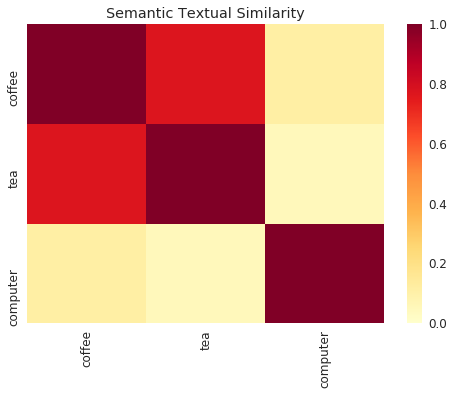

In [27]:
def plot_similarity(labels, embeddings):
  # TODO (done): fill out a len(embeddings) x len(embeddings) array
  corr = cosine_similarity(embeddings)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=90)
  g.set_title("Semantic Textual Similarity")

plot_similarity([word_1, word_2, word_3], my_embeddings)

What you should observe is that, trivially, all words are identical to themselves, and, more interestingly, that the two more similar words have more similar embeddings than the third word.

<h2>Task 3: From Words to Sentences</h2>

Up until now, we've used our module to produce representations of words. But, in fact, if we want to, we can also use it to construct representations of sentences. The methods used by the module to compose a representation of a sentence won't be as nuanced as what an RNN might do, but they are still worth examining because they are so convenient.

<ol>
    <li> Examine the documentation for our hub module and determine how to ask it to construct a representation of a sentence</li>
    <li> Figure out how the module takes word embeddings and uses them to construct sentence embeddings </li>
    <li> Construct a embeddings of a "cat", "The cat sat on the mat", "dog" and "The cat sat on the dog"  and plot their similarity
</ol>

[[ 0.11233182 -0.3176392  -0.01661182 -0.07224456  0.18654485 -0.13343827
   0.14713244 -0.05857142 -0.1187038  -0.09351522  0.3228137  -0.07136346]
 [ 0.30271947  0.06102945  0.2131018   0.3132161  -0.03663905  0.102662
   0.23911574 -0.17047675 -0.00178879  0.02816536  0.25748315  0.23638877]
 [ 0.2350014  -0.24834827 -0.08318911 -0.20803356  0.26615405 -0.00961341
   0.01895271 -0.0715168  -0.11710654 -0.1665802   0.18173145 -0.12773395]
 [ 0.31896552  0.00355632  0.18516172  0.16319734  0.02374659  0.04394899
   0.14411704 -0.24116349  0.02685856  0.00404142  0.2835671   0.11446176]]


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


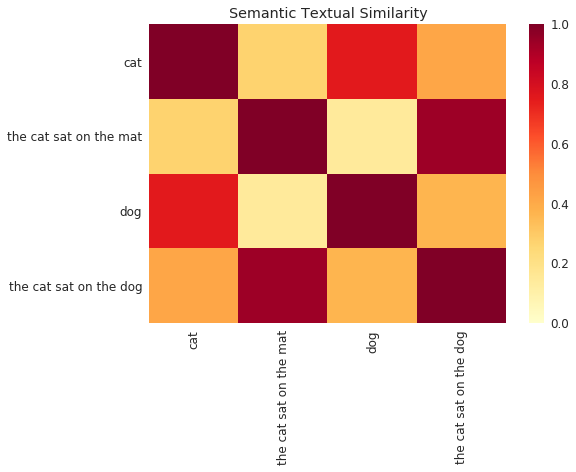

In [33]:
# Task 3
word_list = [
  "cat", 
  "the cat sat on the mat", 
  "dog", 
  "the cat sat on the dog"
]
my_embeddings_tensor = embed(word_list)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    my_embeddings = sess.run(my_embeddings_tensor)

print(my_embeddings[:, :12])
plot_similarity(word_list, my_embeddings)

Which is cat more similar to, "The cat sat on the mat" or "dog"? Is this desireable?

Think back to how an RNN scans a sequence and maintains its state. Naive methods of embedding composition (mapping many to one) can't possibly compete with a network trained for this very purpose!

<h2>Task 4: Assessing the Embeddings Formally</h2>
Of course, it's great to know that our embeddings match our intuitions to an extent, but it'd be better to have a formal, data-driven measure of the quality of the representation.

Researchers have
The [STS Benchmark](http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark) provides an intristic evaluation of the degree to which similarity scores computed using sentence embeddings align with human judgements. The benchmark requires systems to return similarity scores for a diverse selection of sentence pairs. Pearson correlation is then used to evaluate the quality of the machine similarity scores against human judgements.

In [39]:
def load_sts_dataset(filename):
  # Loads a subset of the STS dataset into a DataFrame. In particular both
  # sentences and their human rated similarity score.
  sent_pairs = []
  with tf.gfile.GFile(filename, "r") as f:
    for line in f:
      ts = line.strip().split("\t")
      # (sent_1, sent_2, similarity_score)
      sent_pairs.append((ts[5], ts[6], float(ts[4])))
  return pd.DataFrame(sent_pairs, columns=["sent_1", "sent_2", "sim"])


def download_and_load_sts_data():
  sts_dataset = tf.keras.utils.get_file(
      fname="Stsbenchmark.tar.gz",
      origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
      extract=True)

  sts_dev = load_sts_dataset(
      os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"))
  sts_test = load_sts_dataset(
      os.path.join(
          os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"))

  return sts_dev, sts_test


sts_dev, sts_test = download_and_load_sts_data()

In [40]:
sts_dev.head()

,sent_1,sent_2,sim
0,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.,5.00
1,A young child is riding a horse.,A child is riding a horse.,4.75
2,A man is feeding a mouse to a snake.,The man is feeding a mouse to the snake.,5.00
3,A woman is playing the guitar.,A man is playing guitar.,2.40
4,A woman is playing the flute.,A man is playing a flute.,2.75


<h3>Build the Evaluation Graph</h3>

Next, we need to build the evaluation graph.

In [41]:
sts_input1 = tf.placeholder(tf.string, shape=(None))
sts_input2 = tf.placeholder(tf.string, shape=(None))

# For evaluation we use exactly normalized rather than
# approximately normalized.
sts_encode1 = tf.nn.l2_normalize(embed(sts_input1), axis=1)
sts_encode2 = tf.nn.l2_normalize(embed(sts_input2), axis=1)
cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
sim_scores = 1.0 - tf.acos(clip_cosine_similarities)

<h3>Evaluate Sentence Embeddings</h3>

Finally, we need to create a session and run our evaluation.

In [42]:
sts_data = sts_dev #@param ["sts_dev", "sts_test"] {type:"raw"}

In [48]:
text_a = sts_data['sent_1'].tolist()
text_b = sts_data['sent_2'].tolist()
dev_scores = sts_data['sim'].tolist()

print(text_a[:5])
print(text_b[:5])
print(dev_scores[:5])

def run_sts_benchmark(session):
  """Returns the similarity scores"""
  emba, embb, scores = session.run(
      [sts_encode1, sts_encode2, sim_scores],
      feed_dict={
          sts_input1: text_a,
          sts_input2: text_b
      })
  return scores


with tf.Session() as session:
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  scores = run_sts_benchmark(session)

pearson_correlation = scipy.stats.pearsonr(scores, dev_scores)
print('\nPearson correlation coefficient = {0}\nExplained variance = {1}\np-value = {2}'.format(
    pearson_correlation[0], pearson_correlation[0]**2, pearson_correlation[1]))

['A man with a hard hat is dancing.', 'A young child is riding a horse.', 'A man is feeding a mouse to a snake.', 'A woman is playing the guitar.', 'A woman is playing the flute.']
['A man wearing a hard hat is dancing.', 'A child is riding a horse.', 'The man is feeding a mouse to the snake.', 'A man is playing guitar.', 'A man is playing a flute.']
[5.0, 4.75, 5.0, 2.4, 2.75]

Pearson correlation coefficient = 0.5184415561190069
Explained variance = 0.26878164711109737
p-value = 5.886987186745979e-104


<h3>Extra Credit</h3>

For extra credit, re-run this analysis with a different Hub module. Are the results different? If so, how?

In [54]:
## =============================================================== ##
## define input words
## =============================================================== ##

word_list = [
  "cat", 
  "the cat sat on the mat", 
  "dog", 
  "the cat sat on the dog"
]

## tensorflow hub:
## https://tfhub.dev/


INFO:tensorflow:Initialize variable module_12/embeddings/part_0:0 from checkpoint b'/tmp/tfhub_modules/7f07056e3a4c9f125d5bd920ef3883605d8556a8/variables/variables' with embeddings


I0315 08:47:20.012620 140120625735424 tf_logging.py:116] Initialize variable module_12/embeddings/part_0:0 from checkpoint b'/tmp/tfhub_modules/7f07056e3a4c9f125d5bd920ef3883605d8556a8/variables/variables' with embeddings


[[ 0.11233182 -0.3176392  -0.01661182 -0.07224456  0.18654485 -0.13343827
   0.14713244 -0.05857142 -0.1187038  -0.09351522  0.3228137  -0.07136346]
 [ 0.30271947  0.06102945  0.2131018   0.3132161  -0.03663905  0.102662
   0.23911574 -0.17047675 -0.00178879  0.02816536  0.25748315  0.23638877]
 [ 0.2350014  -0.24834827 -0.08318911 -0.20803356  0.26615405 -0.00961341
   0.01895271 -0.0715168  -0.11710654 -0.1665802   0.18173145 -0.12773395]
 [ 0.31896552  0.00355632  0.18516172  0.16319734  0.02374659  0.04394899
   0.14411704 -0.24116349  0.02685856  0.00404142  0.2835671   0.11446176]]


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


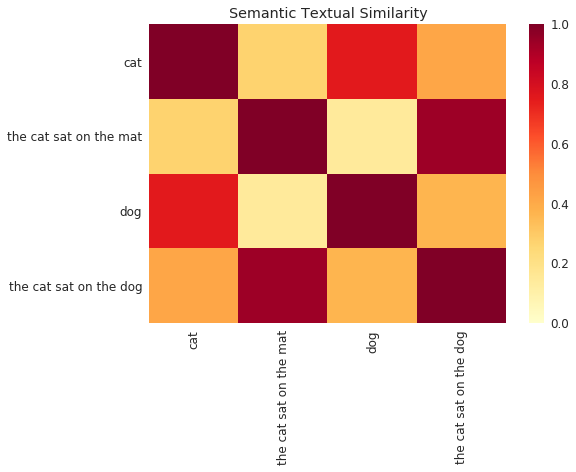

In [55]:

## =============================================================== ##
## nnlm-en-dim50/1
## =============================================================== ##

embed = hub.Module("https://tfhub.dev/google/nnlm-en-dim50/1")
my_embeddings_tensor = embed(word_list)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    my_embeddings = sess.run(my_embeddings_tensor)

print("shape = ", my_embeddings.shape)
print(my_embeddings[:, :12])
plot_similarity(word_list, my_embeddings)



INFO:tensorflow:Initialize variable module_13/aggregation/scaling:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/scaling


I0315 08:50:01.714828 140120625735424 tf_logging.py:116] Initialize variable module_13/aggregation/scaling:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/scaling


INFO:tensorflow:Initialize variable module_13/aggregation/weights:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/weights


I0315 08:50:01.776564 140120625735424 tf_logging.py:116] Initialize variable module_13/aggregation/weights:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/weights


INFO:tensorflow:Initialize variable module_13/bilm/CNN/W_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_0


I0315 08:50:01.784809 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/CNN/W_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_0


INFO:tensorflow:Initialize variable module_13/bilm/CNN/W_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_1


I0315 08:50:01.798007 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/CNN/W_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_1


INFO:tensorflow:Initialize variable module_13/bilm/CNN/W_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_2


I0315 08:50:01.820652 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/CNN/W_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_2


INFO:tensorflow:Initialize variable module_13/bilm/CNN/W_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_3


I0315 08:50:01.839386 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/CNN/W_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_3


INFO:tensorflow:Initialize variable module_13/bilm/CNN/W_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_4


I0315 08:50:01.863701 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/CNN/W_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_4


INFO:tensorflow:Initialize variable module_13/bilm/CNN/W_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_5


I0315 08:50:01.879270 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/CNN/W_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_5


INFO:tensorflow:Initialize variable module_13/bilm/CNN/W_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_6


I0315 08:50:01.897746 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/CNN/W_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_6


INFO:tensorflow:Initialize variable module_13/bilm/CNN/b_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_0


I0315 08:50:01.952949 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/CNN/b_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_0


INFO:tensorflow:Initialize variable module_13/bilm/CNN/b_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_1


I0315 08:50:01.972110 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/CNN/b_cnn_1:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_1


INFO:tensorflow:Initialize variable module_13/bilm/CNN/b_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_2


I0315 08:50:01.996576 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/CNN/b_cnn_2:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_2


INFO:tensorflow:Initialize variable module_13/bilm/CNN/b_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_3


I0315 08:50:02.012564 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/CNN/b_cnn_3:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_3


INFO:tensorflow:Initialize variable module_13/bilm/CNN/b_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_4


I0315 08:50:02.020561 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/CNN/b_cnn_4:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_4


INFO:tensorflow:Initialize variable module_13/bilm/CNN/b_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_5


I0315 08:50:02.060408 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/CNN/b_cnn_5:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_5


INFO:tensorflow:Initialize variable module_13/bilm/CNN/b_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_6


I0315 08:50:02.079428 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/CNN/b_cnn_6:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/b_cnn_6


INFO:tensorflow:Initialize variable module_13/bilm/CNN_high_0/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_carry


I0315 08:50:02.130704 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/CNN_high_0/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_carry


INFO:tensorflow:Initialize variable module_13/bilm/CNN_high_0/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_transform


I0315 08:50:02.153106 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/CNN_high_0/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/W_transform


INFO:tensorflow:Initialize variable module_13/bilm/CNN_high_0/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_carry


I0315 08:50:02.196716 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/CNN_high_0/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_carry


INFO:tensorflow:Initialize variable module_13/bilm/CNN_high_0/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_transform


I0315 08:50:02.213559 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/CNN_high_0/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_0/b_transform


INFO:tensorflow:Initialize variable module_13/bilm/CNN_high_1/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_carry


I0315 08:50:02.230593 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/CNN_high_1/W_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_carry


INFO:tensorflow:Initialize variable module_13/bilm/CNN_high_1/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_transform


I0315 08:50:02.263091 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/CNN_high_1/W_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/W_transform


INFO:tensorflow:Initialize variable module_13/bilm/CNN_high_1/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_carry


I0315 08:50:02.289458 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/CNN_high_1/b_carry:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_carry


INFO:tensorflow:Initialize variable module_13/bilm/CNN_high_1/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_transform


I0315 08:50:02.310333 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/CNN_high_1/b_transform:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_high_1/b_transform


INFO:tensorflow:Initialize variable module_13/bilm/CNN_proj/W_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/W_proj


I0315 08:50:02.325079 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/CNN_proj/W_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/W_proj


INFO:tensorflow:Initialize variable module_13/bilm/CNN_proj/b_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/b_proj


I0315 08:50:02.337744 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/CNN_proj/b_proj:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN_proj/b_proj


INFO:tensorflow:Initialize variable module_13/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


I0315 08:50:02.361901 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module_13/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


I0315 08:50:02.387736 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module_13/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


I0315 08:50:02.419080 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module_13/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


I0315 08:50:02.442580 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module_13/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


I0315 08:50:02.458313 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module_13/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


I0315 08:50:02.494115 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module_13/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


I0315 08:50:02.516907 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module_13/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


I0315 08:50:02.542082 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module_13/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


I0315 08:50:02.563920 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module_13/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


I0315 08:50:02.582647 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias


INFO:tensorflow:Initialize variable module_13/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


I0315 08:50:02.589424 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel


INFO:tensorflow:Initialize variable module_13/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


I0315 08:50:02.596203 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel


INFO:tensorflow:Initialize variable module_13/bilm/char_embed:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/char_embed


I0315 08:50:02.625547 140120625735424 tf_logging.py:116] Initialize variable module_13/bilm/char_embed:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/char_embed


[[ 7.86503792e-01 -3.25359493e-01  1.23189531e-01 -6.31738663e-01
   1.88567102e-01  2.76136607e-01  1.73851952e-01 -8.03314567e-01
  -5.10990977e-01 -1.16187096e+00 -6.06740057e-01  2.91882157e-02]
 [ 6.98237792e-02  5.04003316e-02 -1.51206419e-01  2.53290832e-02
   2.45259795e-02  1.18018286e-02  1.13990434e-01  1.37679130e-01
  -4.49989773e-02 -1.12476073e-01 -2.47298107e-01 -2.86568012e-02]
 [ 4.81288075e-01 -9.09860373e-01  6.74559593e-01 -8.07523847e-01
   1.12680510e-01  3.45564783e-01  3.07820261e-01 -7.63921738e-01
  -3.25469762e-01 -1.29056954e+00 -2.94639409e-01  3.13401520e-02]
 [ 7.13173673e-02 -7.98780322e-02 -1.68966487e-01 -1.38571160e-02
   3.67775895e-02  4.18129154e-02  1.15448005e-01  5.17846942e-02
  -8.63274038e-02 -1.38330460e-01 -2.83773988e-01 -4.24553960e-04]]


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


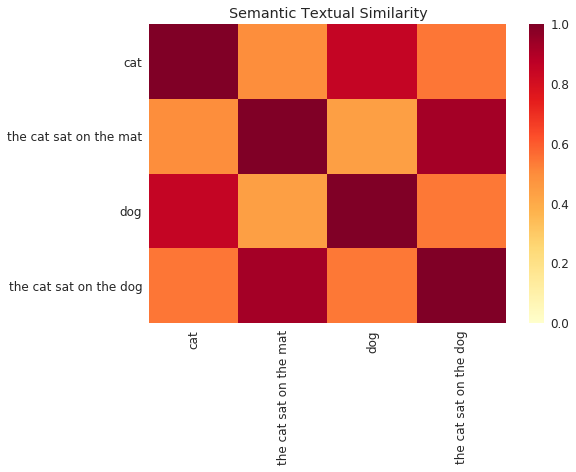

In [56]:

## =============================================================== ##
## elmo/2
## =============================================================== ##

embed = hub.Module("https://tfhub.dev/google/elmo/2", trainable = True)
my_embeddings_tensor = embed(word_list, signature = "default", as_dict = True)["default"]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    my_embeddings = sess.run(my_embeddings_tensor)

print("shape = ", my_embeddings.shape)
print(my_embeddings[:, :12])
plot_similarity(word_list, my_embeddings)

In [ ]:

## =============================================================== ##
## build evaluation graph (again, just to make sure)
## =============================================================== ##

sts_input1 = tf.placeholder(tf.string, shape=(None))
sts_input2 = tf.placeholder(tf.string, shape=(None))

# For evaluation we use exactly normalized rather than
# approximately normalized.

## nnlm-en-dim50/1:
#sts_encode1 = tf.nn.l2_normalize(embed(sts_input1), axis=1)
#sts_encode2 = tf.nn.l2_normalize(embed(sts_input2), axis=1)

## elmo/2:
sts_encode1 = tf.nn.l2_normalize(embed(sts_input1, signature = "default", as_dict = True)["default"], axis = 1)
sts_encode2 = tf.nn.l2_normalize(embed(sts_input2, signature = "default", as_dict = True)["default"], axis = 1)

## compute similarities:
cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
sim_scores = 1.0 - tf.acos(clip_cosine_similarities)

sts_data = sts_dev #@param ["sts_dev", "sts_test"] {type:"raw"}

text_a = sts_data['sent_1'].tolist()
text_b = sts_data['sent_2'].tolist()
dev_scores = sts_data['sim'].tolist()

## =============================================================== ##
## evaluate the model with sts benchmark
## =============================================================== ##

with tf.Session() as session:
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  scores = run_sts_benchmark(session)

pearson_correlation = scipy.stats.pearsonr(scores, dev_scores)
print('\nPearson correlation coefficient = {0}\nExplained variance = {1}\np-value = {2}'.format(
    pearson_correlation[0], pearson_correlation[0]**2, pearson_correlation[1]))

<h2>Further Reading</h2>

We published a [blog post](https://developers.googleblog.com/2018/04/text-embedding-models-contain-bias.html) on how bias can affect text embeddings. It's worth a read!